In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Read the Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')

In [3]:
ice_cream_heater_df = pd.read_csv('ice_cream_vs_heater.csv', parse_dates=[0], index_col=0, date_format=parser)

In [4]:
ice_cream_heater_df.head()

,heater,ice cream
Month,,
2004-01,27,13
2004-02,18,15
2004-03,14,16
2004-04,13,19
2004-05,13,21


In [ ]:
# heater	ice cream
# Month		
# 2004-01	27	13
# 2004-02	18	15
# 2004-03	14	16
# 2004-04	13	19
# 2004-05	13	21

In [5]:
pd.infer_freq(ice_cream_heater_df.index)

'MS'

In [6]:
ice_cream_heater_df["Month"] = pd.to_datetime(ice_cream_heater_df.index)
ice_cream_heater_df.set_index("Month", inplace=True)


In [7]:
# ice_cream_heater_df = ice_cream_heater_df.asfreq(pd.infer_freq(ice_cream_heater_df.index))

In [8]:
heater_series = ice_cream_heater_df.heater

In [9]:
heater_series

Month
2004-01-01    27
2004-02-01    18
2004-03-01    14
2004-04-01    13
2004-05-01    13
              ..
2020-02-01    34
2020-03-01    25
2020-04-01    25
2020-05-01    27
2020-06-01    24
Name: heater, Length: 198, dtype: int64

In [10]:
heater_series_org = heater_series

In [11]:
def plot_series(series):
    plt.figure(figsize=(12,6))
    plt.plot(heater_series, color='red')
    plt.ylabel('Search Frequency for "Heater"', fontsize=16)

    for year in range(2004, 2021):
        plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

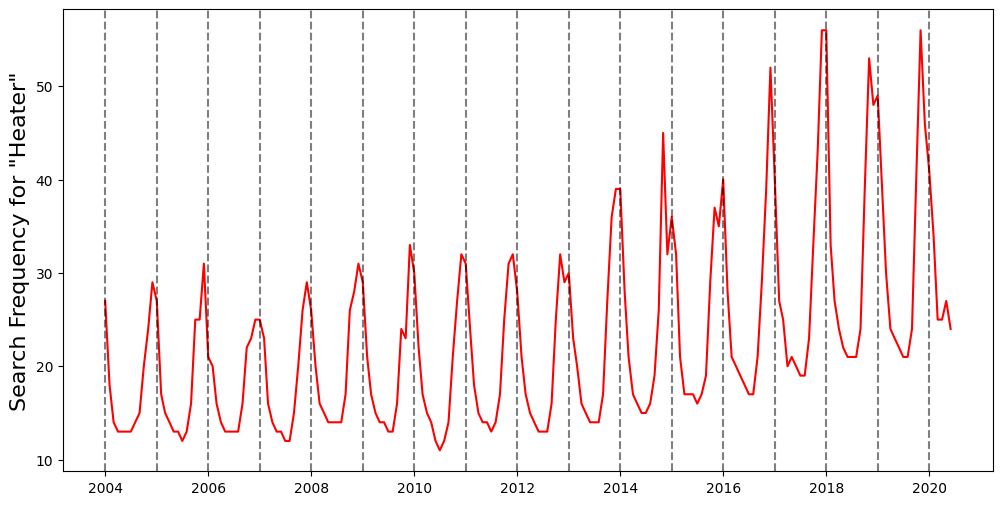

In [12]:
plot_series(heater_series)

# Normalize

In [13]:
avg, dev = heater_series.mean(), heater_series.std()

In [14]:
heater_series = (heater_series - avg) / dev

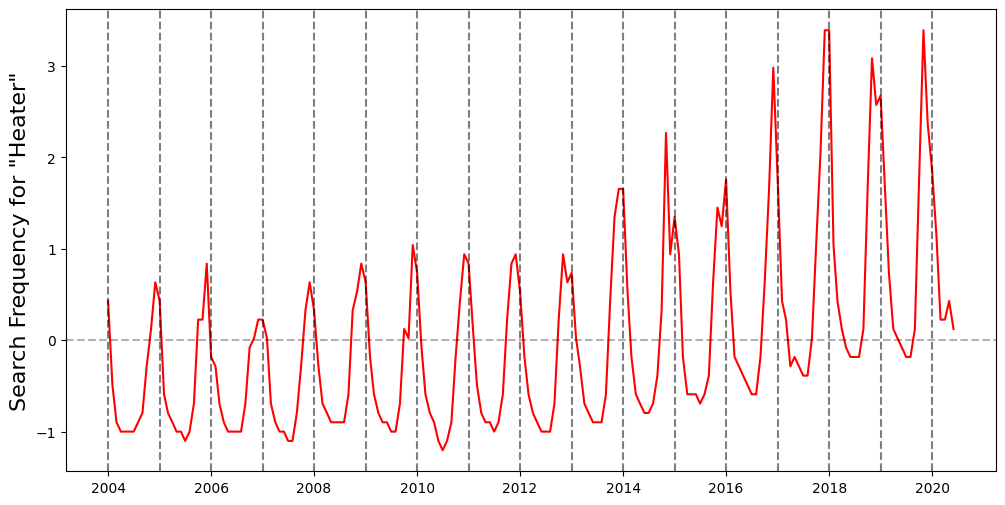

In [15]:
plot_series(heater_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

# Take First Difference to Remove Trend

In [16]:
heater_series = heater_series.diff().dropna()

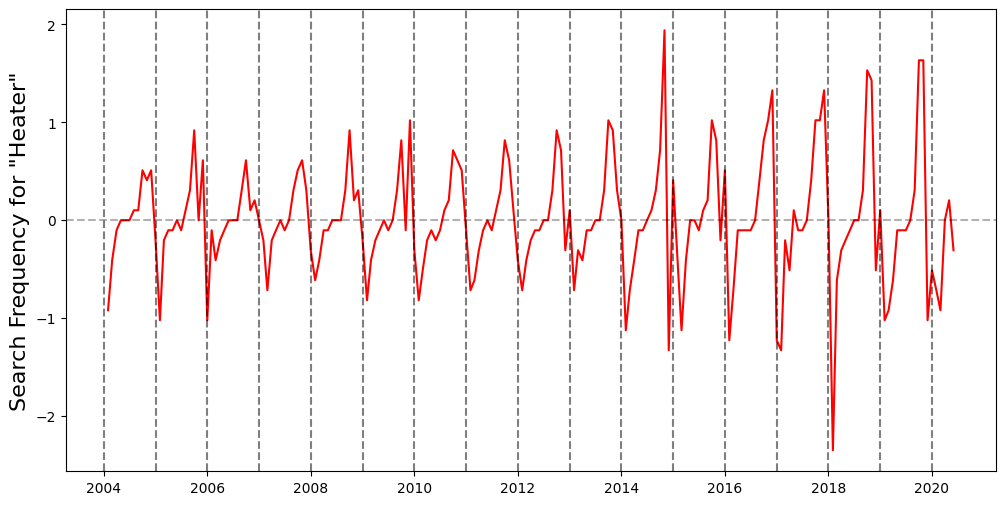

In [17]:
plot_series(heater_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

# Remove Increasing Volatility

In [18]:
annual_volatility = heater_series.groupby(heater_series.index.year).std()

In [ ]:
annual_volatility

In [20]:
heater_annual_vol = heater_series.index.map(lambda d: annual_volatility.loc[d.year])

In [ ]:
heater_annual_vol

In [22]:
heater_series = heater_series / heater_annual_vol

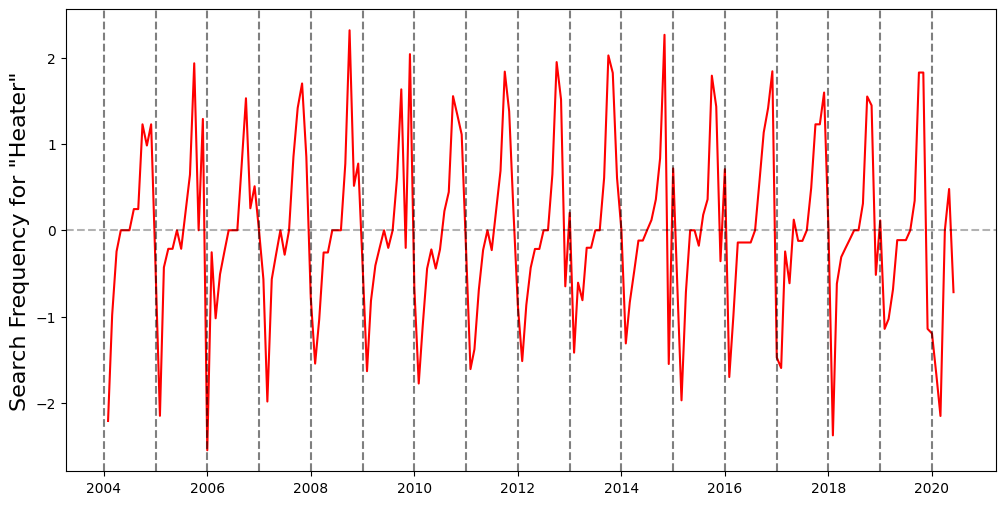

In [23]:
plot_series(heater_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

In [ ]:
plot_acf(heater_series, lags= 25);

In [ ]:
plot_pacf(heater_series, lags= 26);

In [731]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
perform_adf_test(heater_series)

ADF Statistic: -2.151327
p-value: 0.224382


In [ ]:
# Remove Seasonality


month_avgs = heater_series.groupby(heater_series.index.month).mean()
month_avgs
heater_month_avg = heater_series.index.map(lambda d: month_avgs.loc[d.month])
heater_month_avg
heater_series = heater_series - heater_month_avg
plot_series(heater_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)



# when applying sarimax removing seasonality is not necessary  SARIMAX explicitly accounts for both seasonal and non-seasonal components in the model.


## Perform Dicky Fuller Test to Check Stationarity

In [733]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
perform_adf_test(heater_series)

ADF Statistic: -14.280161
p-value: 0.000000


## ACF 

In [ ]:
plot_acf(x = heater_series, lags= 20 );

## Based on ACF, we should start with a seasonal MA process

In [ ]:
plot_pacf(heater_series, lags= 20);

## Based on ACF, we should start with a seasonal AR process

# Get training and testing sets

In [736]:
train_end = datetime(2016,12,1)
test_end = datetime(2020,6,1)

train_data = heater_series_org[:train_end]
test_data = heater_series_org[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model

In [ ]:
plt.plot(train_data)

In [ ]:
plt.plot((test_data))

In [ ]:
my_order_1 = (0,1,0)
my_seasonal_order_1 = (1, 1, 1, 12)
my_order_2 = (0,1,1)
my_seasonal_order_2 = (2, 1, 0, 12)
# define model
model1 = SARIMAX(train_data, order=my_order_1, seasonal_order=my_seasonal_order_1)
model2 = SARIMAX(train_data, order=my_order_2, seasonal_order=my_seasonal_order_2)

In [740]:
#fit the model
start = time()
model_fit1 = model1.fit()
end = time()
print('Model Fitting Time:', end - start)
#fit the model
start = time()
model_fit2 = model2.fit()
end = time()
print('Model Fitting Time:', end - start)


Model Fitting Time: 0.16476178169250488
Model Fitting Time: 0.2714061737060547


In [ ]:
#summary of the model
print(model_fit1.summary())

In [ ]:
# SARIMAX Results                                       
# ============================================================================================
# Dep. Variable:                               heater   No. Observations:                  156
# Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -364.914
# Date:                              Fri, 17 Jan 2025   AIC                            735.828
# Time:                                      05:08:14   BIC                            744.716
# Sample:                                  01-01-2004   HQIC                           739.439
#                                        - 12-01-2016                                         
# Covariance Type:                                opg                                         
# ==============================================================================
#                  coef    std err          z      P>|z|      [0.025      0.975]
# ------------------------------------------------------------------------------
# ar.S.L12       0.1160      0.104      1.119      0.263      -0.087       0.319
# ma.S.L12      -0.7274      0.047    -15.630      0.000      -0.819      -0.636
# sigma2         9.1734      0.461     19.884      0.000       8.269      10.078
# ===================================================================================
# Ljung-Box (L1) (Q):                  19.05   Jarque-Bera (JB):               539.43
# Prob(Q):                              0.00   Prob(JB):                         0.00
# Heteroskedasticity (H):               3.27   Skew:                             0.39
# Prob(H) (two-sided):                  0.00   Kurtosis:                        12.48
# ===================================================================================

# Warnings:
# [1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [ ]:
print(model_fit2.summary())

In [ ]:
# SARIMAX Results                                      
# ===========================================================================================
# Dep. Variable:                              heater   No. Observations:                  156
# Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -334.188
# Date:                             Fri, 17 Jan 2025   AIC                            676.376
# Time:                                     05:08:14   BIC                            688.228
# Sample:                                 01-01-2004   HQIC                           681.192
#                                       - 12-01-2016                                         
# Covariance Type:                               opg                                         
# ==============================================================================
#                  coef    std err          z      P>|z|      [0.025      0.975]
# ------------------------------------------------------------------------------
# ma.L1         -0.8895      0.036    -24.584      0.000      -0.960      -0.819
# ar.S.L12      -0.5878      0.072     -8.210      0.000      -0.728      -0.447
# ar.S.L24      -0.5167      0.052     -9.858      0.000      -0.619      -0.414
# sigma2         5.7955      0.429     13.524      0.000       4.956       6.635
# ===================================================================================
# Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               281.73
# Prob(Q):                              0.60   Prob(JB):                         0.00
# Heteroskedasticity (H):               3.36   Skew:                             1.58
# Prob(H) (two-sided):                  0.00   Kurtosis:                         9.11
# ===================================================================================

# Warnings:
# [1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [743]:
#get the predictions and residuals
predictions1 = model_fit1.forecast(len(test_data))
predictions1 = pd.Series(predictions1, index=test_data.index)
residuals1 = test_data - predictions1

#get the predictions and residuals
predictions2 = model_fit2.forecast(len(test_data))
predictions2 = pd.Series(predictions2, index=test_data.index)
residuals2 = test_data - predictions2

Text(0, 0.5, 'Error')

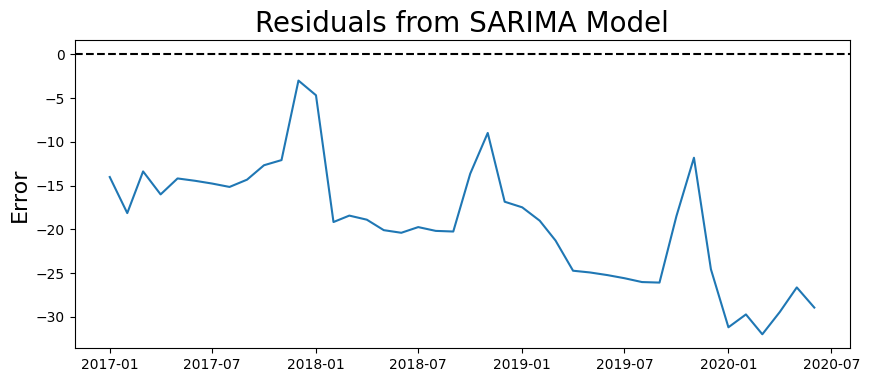

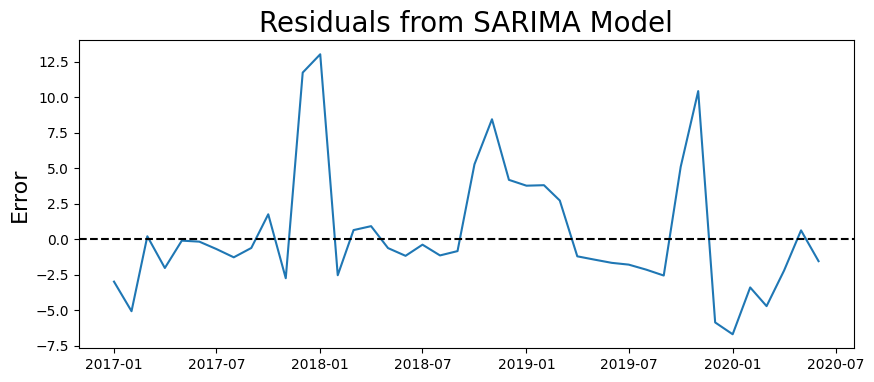

In [744]:
plt.figure(figsize=(10,4))
plt.plot(residuals1)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

plt.figure(figsize=(10,4))
plt.plot(residuals2)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

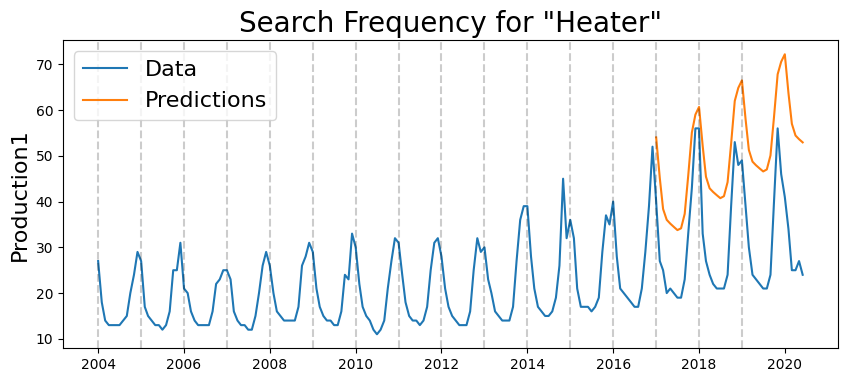

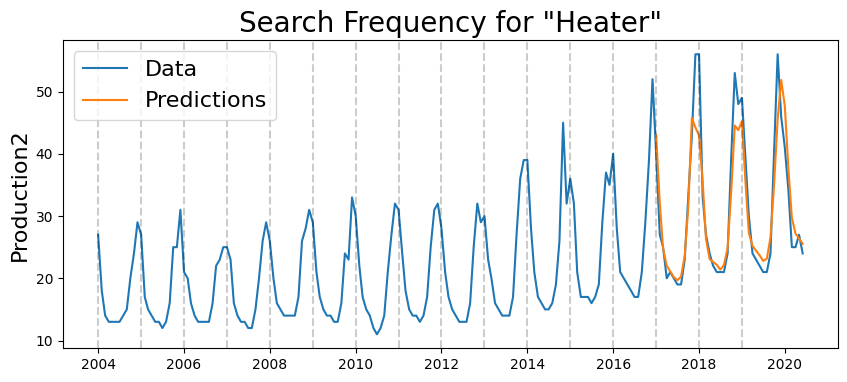

In [745]:

plt.figure(figsize=(10,4))

plt.plot(heater_series_org)
plt.plot(predictions1)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Search Frequency for "Heater"', fontsize=20)
plt.ylabel('Production1', fontsize=16)
start_date = datetime(2004,1,1)
end_date = datetime(2020,6,1)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    

plt.figure(figsize=(10,4))

plt.plot(heater_series_org)
plt.plot(predictions2)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Search Frequency for "Heater"', fontsize=20)
plt.ylabel('Production2', fontsize=16)
start_date = datetime(2004,1,1)
end_date = datetime(2020,6,1)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    

In [746]:
print('Mean Absolute Percent Error from model 1 :', round(np.mean(abs(residuals1/test_data)),4))
print('Mean Absolute Percent Error from model 2 :', round(np.mean(abs(residuals2/test_data)),4))

Mean Absolute Percent Error from model 1 : 0.7181
Mean Absolute Percent Error from model 2 : 0.0859


In [747]:
print('Root Mean Squared Error from model 1 :', np.sqrt(np.mean(residuals1**2)))
print('Root Mean Squared Error from model 2 :', np.sqrt(np.mean(residuals2**2)))

Root Mean Squared Error from model 1 : 20.345523706972468
Root Mean Squared Error from model 2 : 4.368717902281931


In [ ]:
rolling_predictions1 = test_data.copy()
rolling_predictions2 = test_data.copy()
for train_end in test_data.index:
    train_data = heater_series_org[:train_end-timedelta(days=1)]
    model1 = SARIMAX(train_data, order=my_order_1, seasonal_order=my_seasonal_order_1)
    model2 = SARIMAX(train_data, order=my_order_2, seasonal_order=my_seasonal_order_2)
    model_fit1 = model1.fit()
    model_fit2 = model2.fit()
    pred1 = model_fit1.forecast()
    pred2 = model_fit2.forecast()
    rolling_predictions1[train_end] = pred1
    rolling_predictions2[train_end] = pred2

In [749]:
rolling_residuals1 = test_data - rolling_predictions1
rolling_residuals2 = test_data - rolling_predictions2

Text(0, 0.5, 'Error')

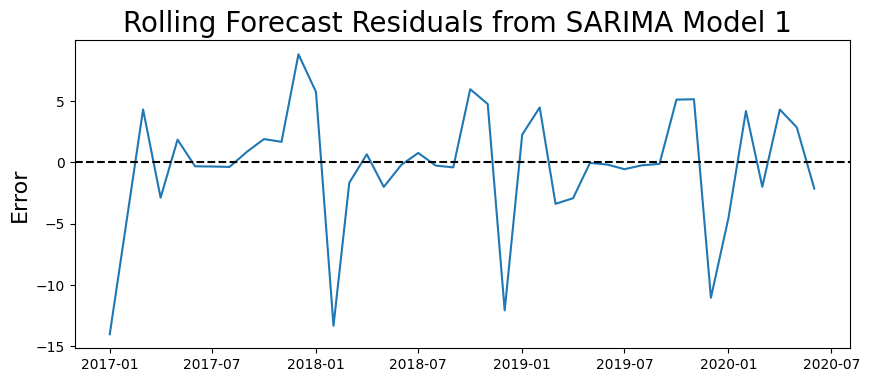

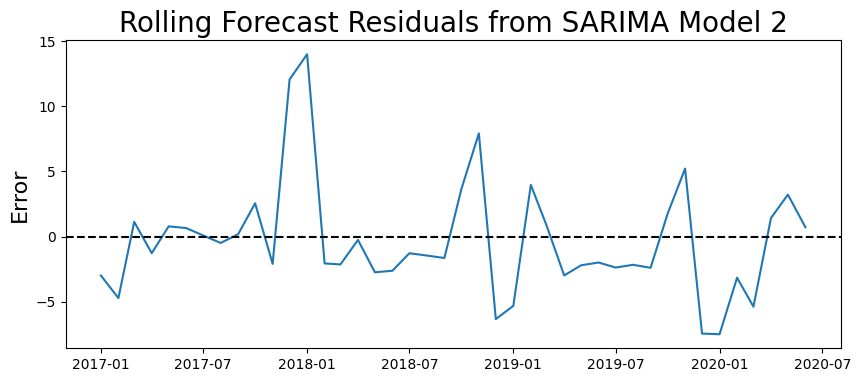

In [750]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals1)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model 1 ', fontsize=20)
plt.ylabel('Error', fontsize=16)

plt.figure(figsize=(10,4))
plt.plot(rolling_residuals2)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model 2', fontsize=20)
plt.ylabel('Error', fontsize=16)

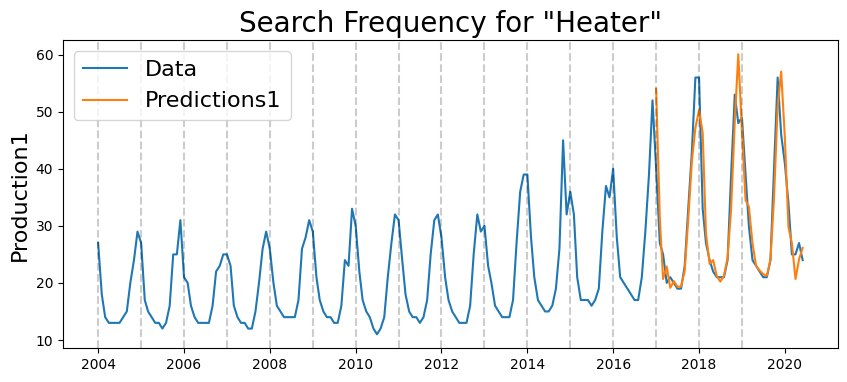

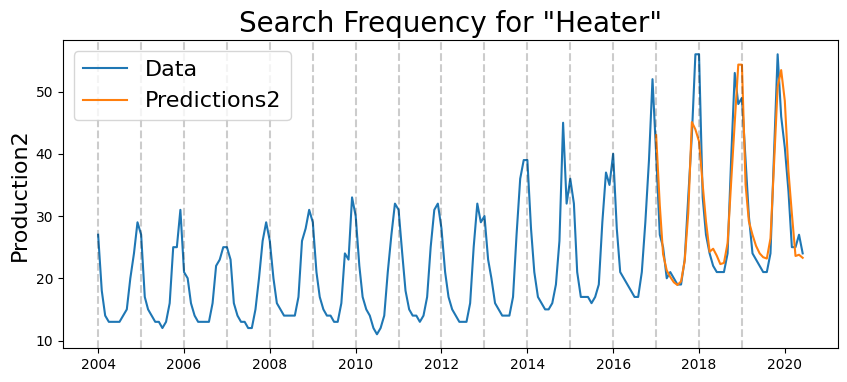

In [751]:
plt.figure(figsize=(10,4))

plt.plot(heater_series_org)
plt.plot(rolling_predictions1)

plt.legend(('Data', 'Predictions1'), fontsize=16)

plt.title('Search Frequency for "Heater"', fontsize=20)
plt.ylabel('Production1', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    

plt.figure(figsize=(10,4))

plt.plot(heater_series_org)
plt.plot(rolling_predictions2)

plt.legend(('Data', 'Predictions2'), fontsize=16)

plt.title('Search Frequency for "Heater"', fontsize=20)
plt.ylabel('Production2', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [752]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals1/test_data)),4))
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals2/test_data)),4))

Mean Absolute Percent Error: 0.0979
Mean Absolute Percent Error: 0.0928


In [753]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals1**2)))
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals2**2)))

Root Mean Squared Error: 4.997311291150917
Root Mean Squared Error: 4.384230038469562
